In [1]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np

import brainpy as bp
import brainpy.math as bm


# **The Cortical Network Model for Decision-Making**

The network is composed of N neurons, with NE pyramidal cells (80%) and NI interneurons (20%) (Braitenberg and Schütz 1991).
Simulations reported in here were done with NE = 1600, NI = 400.
Each stimulus activates a distinct and small subpopulation of fNE excitatory cells (f = 0.15). 

**Neurons**

Both pyramidal cells and interneurons are described by leaky integrate-and-fire neurons (see for example Tuckwell 1988) and are characterized by a resting potential VL = −70 mV, a firing threshold Vth = −50 mV, a reset potential Vreset = −55 mV, a membrane capacitance Cm = 0.5 nF for pyramidal cells and 0.2 nF for interneurons, a membrane leak conductance gL = 25 nS for pyramidal cells and 20 nS for interneurons, and a refractory period τref = 2 ms for pyramidal cells and 1 ms for interneurons. The corresponding membrane time constants are τm = Cm/gL = 20 ms for excitatory cells and 10 ms for interneurons (McCormick et al. 1985). Below threshold, the membrane potential V(t) of a cell 

$$
C_m \frac{d V(t)}{d t}=-g_L\left(V(t)-V_L\right)-I_{s y n}(t)
$$

where Isyn(t) represents the total synaptic current flowing into the cell.


**Synapses**

The total synaptic currents are given by:

$$
I_{s y n}(t)=I_{\text {ext,AMPA }}(t)+I_{\text {rec }, A M P A}(t)+I_{\text {rec }, N M D A}(t)+I_{\text {rec }, \mathrm{GABA}}(t)
$$

in which

$$
\begin{gathered}
I_{\text {ext,AMPA }}(t)=g_{\text {ext,AMPA }}\left(V(t)-V_E\right) s^{\text {ext,AMPA }}(t) \\
I_{\text {rec,AMPA }}(t)=g_{\text {rec,AMPA }}\left(V(t)-V_E\right) \sum_{j=1}^{C_E} w_j s_j^{A M P A}(t) \\
I_{\text {rec,NMDA }}(t)=\frac{g_{\mathrm{NMDA}}\left(V(t)-V_E\right)}{\left(1+\left[\mathrm{Mg}^{2+}\right] \exp (-0.062 V(t)) / 3.57\right)} \sum_{j=1}^{\mathrm{C}_E} w_j s_j^{\mathrm{NMDA}}(t) \\
I_{\mathrm{rec}, \mathrm{GABA}}(t)=g_{\mathrm{GABA}}\left(V(t)-V_l\right) \sum_{j=1}^{C_1} s_j^{\mathrm{GABA}}(t)
\end{gathered}
$$

where VE = 0 mV, VI = −70 mV. 

**Synaptic Weights**

Hence, inside a selective population, $w_j$ = w+, where w+ > 1 is a dimensionless parameter that is equal to the relative strength of “potentiated” synapses with respect to the baseline. Unless specified otherwise, I used w+ = 1.7. 

Between two different selective populations, and from the nonselective population to selective ones, $w_j$ = w−, where w− < 1 measures the strength of synaptic “depression.” $w− = 1 − f(w_+ − 1)/(1 − f)$.

Other connections have $w_j$ = 1.


**References:**

-Wang XJ. Probabilistic Decision Making by Slow Reverberation in Cortical Circuits. Neuron. 2002;36(5):955-968. doi:10.1016/S0896-6273(02)01092-9


In [2]:
class AMPA(bp.Projection):
  def __init__(self, pre, post, conn, delay, g_max, tau, E):
    super().__init__()
    if conn == 'all2all':
      comm = bp.dnn.AllToAll(pre.num, post.num, g_max)
    elif conn == 'one2one':
      comm = bp.dnn.OneToOne(pre.num, g_max)
    else:
      raise ValueError
    syn = bp.dyn.Expon.desc(post.num, tau=tau)
    out = bp.dyn.COBA.desc(E=E)
    self.proj = bp.dyn.ProjAlignPostMg2(
      pre=pre, delay=delay, comm=comm,
      syn=syn, out=out, post=post
    )


class NMDA(bp.Projection):
  def __init__(self, pre, post, conn, delay, g_max):
    super().__init__()
    if conn == 'all2all':
      comm = bp.dnn.AllToAll(pre.num, post.num, g_max)
    elif conn == 'one2one':
      comm = bp.dnn.OneToOne(pre.num, g_max)
    else:
      raise ValueError
    syn = bp.dyn.NMDA.desc(pre.num, a=0.5, tau_decay=100., tau_rise=2.)
    out = bp.dyn.MgBlock(E=0., cc_Mg=1.0)
    self.proj = bp.dyn.ProjAlignPreMg2(
      pre=pre, delay=delay, syn=syn,
      comm=comm, out=out, post=post
    )


In [3]:
class DecisionMakingNet(bp.DynSysGroup):
  def __init__(self, scale=1., f=0.15):
    super().__init__()
    # 网络中各组神经元的数目
    num_exc = int(1600 * scale)
    num_I, num_A, num_B = int(400 * scale), int(f * num_exc), int(f * num_exc)
    num_N = num_exc - num_A - num_B
    self.num_A, self.num_B, self.num_N, self.num_I = num_A, num_B, num_N, num_I

    poisson_freq = 2400.  # Hz
    w_pos = 1.7
    w_neg = 1. - f * (w_pos - 1.) / (1. - f)
    g_ext2E_AMPA = 2.1  # nS
    g_ext2I_AMPA = 1.62  # nS
    g_E2E_AMPA = 0.05 / scale  # nS
    g_E2I_AMPA = 0.04 / scale  # nS
    g_E2E_NMDA = 0.165 / scale  # nS
    g_E2I_NMDA = 0.13 / scale  # nS
    g_I2E_GABAa = 1.3 / scale  # nS
    g_I2I_GABAa = 1.0 / scale  # nS

    neu_par = dict(V_rest=-70., V_reset=-55., V_th=-50., V_initializer=bp.init.OneInit(-70.))

    # E neurons/pyramid neurons
    self.A = bp.dyn.LifRef(num_A, tau=20., R=0.04, tau_ref=2., **neu_par)
    self.B = bp.dyn.LifRef(num_B, tau=20., R=0.04, tau_ref=2., **neu_par)
    self.N = bp.dyn.LifRef(num_N, tau=20., R=0.04, tau_ref=2., **neu_par)

    # I neurons/interneurons
    self.I = bp.dyn.LifRef(num_I, tau=10., R=0.05, tau_ref=1., **neu_par)

    # poisson stimulus  # 'freqs' as bm.Variable
    self.IA = bp.dyn.PoissonGroup(num_A, freqs=bm.Variable(bm.zeros(1)))
    self.IB = bp.dyn.PoissonGroup(num_B, freqs=bm.Variable(bm.zeros(1)))

    # noise neurons
    self.noise_B = bp.dyn.PoissonGroup(num_B, freqs=poisson_freq)
    self.noise_A = bp.dyn.PoissonGroup(num_A, freqs=poisson_freq)
    self.noise_N = bp.dyn.PoissonGroup(num_N, freqs=poisson_freq)
    self.noise_I = bp.dyn.PoissonGroup(num_I, freqs=poisson_freq)

    # define external inputs
    #### TO DO!!!!
    self.IA2A = AMPA(self.IA, self.A, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.IB2B = AMPA(self.IB, self.B, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)

    # define AMPA projections from N
    #### TO DO!!!!
    self.N2B_AMPA = AMPA(self.N, self.B, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.N2A_AMPA = AMPA(self.N, self.A, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.N2N_AMPA = AMPA(self.N, self.N, 'all2all', 0.5, g_E2E_AMPA, tau=2., E=0.)
    self.N2I_AMPA = AMPA(self.N, self.I, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)

    # define NMDA projections from N
    #### TO DO!!!!
    self.N2B_NMDA = NMDA(self.N, self.B, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.N2A_NMDA = NMDA(self.N, self.A, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.N2N_NMDA = NMDA(self.N, self.N, 'all2all', 0.5, g_E2E_NMDA)
    self.N2I_NMDA = NMDA(self.N, self.I, 'all2all', 0.5, g_E2I_NMDA)

    # define AMPA projections from B
    #### TO DO!!!!
    self.B2B_AMPA = AMPA(self.B, self.B, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0.)
    self.B2A_AMPA = AMPA(self.B, self.A, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.B2N_AMPA = AMPA(self.B, self.N, 'all2all', 0.5, g_E2E_AMPA, tau=2., E=0.)
    self.B2I_AMPA = AMPA(self.B, self.I, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)

    # define NMDA projections from B
    #### TO DO!!!!
    self.B2B_NMDA = NMDA(self.B, self.B, 'all2all', 0.5, g_E2E_NMDA * w_pos)
    self.B2A_NMDA = NMDA(self.B, self.A, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.B2N_NMDA = NMDA(self.B, self.N, 'all2all', 0.5, g_E2E_NMDA)
    self.B2I_NMDA = NMDA(self.B, self.I, 'all2all', 0.5, g_E2I_NMDA)

    # define AMPA projections from A
    #### TO DO!!!!
    self.A2B_AMPA = AMPA(self.A, self.B, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.A2A_AMPA = AMPA(self.A, self.A, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0.)
    self.A2N_AMPA = AMPA(self.A, self.N, 'all2all', 0.5, g_E2E_AMPA, tau=2., E=0.)
    self.A2I_AMPA = AMPA(self.A, self.I, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)

    # define NMDA projections from A
    #### TO DO!!!!
    self.A2B_NMDA = NMDA(self.A, self.B, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.A2A_NMDA = NMDA(self.A, self.A, 'all2all', 0.5, g_E2E_NMDA * w_pos)
    self.A2N_NMDA = NMDA(self.A, self.N, 'all2all', 0.5, g_E2E_NMDA)
    self.A2I_NMDA = NMDA(self.A, self.I, 'all2all', 0.5, g_E2I_NMDA)

    # define I->E/I conn
    #### TO DO!!!! 用AMPA()
    self.I2B = AMPA(self.I, self.B, 'all2all', 0.5, g_I2E_GABAa, tau=5., E=-70.)
    self.I2A = AMPA(self.I, self.A, 'all2all', 0.5, g_I2E_GABAa, tau=5., E=-70.)
    self.I2N = AMPA(self.I, self.N, 'all2all', 0.5, g_I2E_GABAa, tau=5., E=-70.)
    self.I2I = AMPA(self.I, self.I, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)

    # define external projections
    #### TO DO!!!!
    self.noise2B = AMPA(self.noise_B, self.B, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.noise2A = AMPA(self.noise_A, self.A, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.noise2N = AMPA(self.noise_N, self.N, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.noise2I = AMPA(self.noise_I, self.I, 'one2one', None, g_ext2I_AMPA, tau=2., E=0.)


In [4]:
class Tool:
  def __init__(self, pre_stimulus_period=100., stimulus_period=1000., delay_period=500.):
    self.pre_stimulus_period = pre_stimulus_period
    self.stimulus_period = stimulus_period
    self.delay_period = delay_period
    self.freq_variance = 10.
    self.freq_interval = 50.
    self.total_period = pre_stimulus_period + stimulus_period + delay_period

  def generate_freqs(self, mean):
    # stimulus period
    n_stim = int(self.stimulus_period / self.freq_interval)
    n_interval = int(self.freq_interval / bm.get_dt())
    freqs_stim = np.random.normal(mean, self.freq_variance, (n_stim, 1))
    freqs_stim = np.tile(freqs_stim, (1, n_interval)).flatten()
    # pre stimulus period
    freqs_pre = np.zeros(int(self.pre_stimulus_period / bm.get_dt()))
    # post stimulus period
    freqs_delay = np.zeros(int(self.delay_period / bm.get_dt()))
    all_freqs = np.concatenate([freqs_pre, freqs_stim, freqs_delay], axis=0)
    return bm.asarray(all_freqs)

  def visualize_results(self, mon, IA_freqs, IB_freqs, t_start=0., title=None):
    fig, gs = bp.visualize.get_figure(4, 1, 3, 10)
    axes = [fig.add_subplot(gs[i, 0]) for i in range(4)]

    ax = axes[0]
    bp.visualize.raster_plot(mon['ts'], mon['A.spike'], markersize=1, ax=ax)
    if title: ax.set_title(title)
    ax.set_ylabel("Group A")
    ax.set_xlim(t_start, self.total_period + 1)
    ax.axvline(self.pre_stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period + self.delay_period, linestyle='dashed')

    ax = axes[1]
    bp.visualize.raster_plot(mon['ts'], mon['B.spike'], markersize=1, ax=ax)
    ax.set_ylabel("Group B")
    ax.set_xlim(t_start, self.total_period + 1)
    ax.axvline(self.pre_stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period + self.delay_period, linestyle='dashed')

    ax = axes[2]
    rateA = bp.measure.firing_rate(mon['A.spike'], width=10.)
    rateB = bp.measure.firing_rate(mon['B.spike'], width=10.)
    ax.plot(mon['ts'], rateA, label="Group A")
    ax.plot(mon['ts'], rateB, label="Group B")
    ax.set_ylabel('Population activity [Hz]')
    ax.set_xlim(t_start, self.total_period + 1)
    ax.axvline(self.pre_stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period + self.delay_period, linestyle='dashed')
    ax.legend()

    ax = axes[3]
    ax.plot(mon['ts'], IA_freqs, label="group A")
    ax.plot(mon['ts'], IB_freqs, label="group B")
    ax.set_ylabel("Input activity [Hz]")
    ax.set_xlim(t_start, self.total_period + 1)
    ax.axvline(self.pre_stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period + self.delay_period, linestyle='dashed')
    ax.legend()
    ax.set_xlabel("Time [ms]")

    plt.show()

  0%|          | 0/16000 [00:00<?, ?it/s]

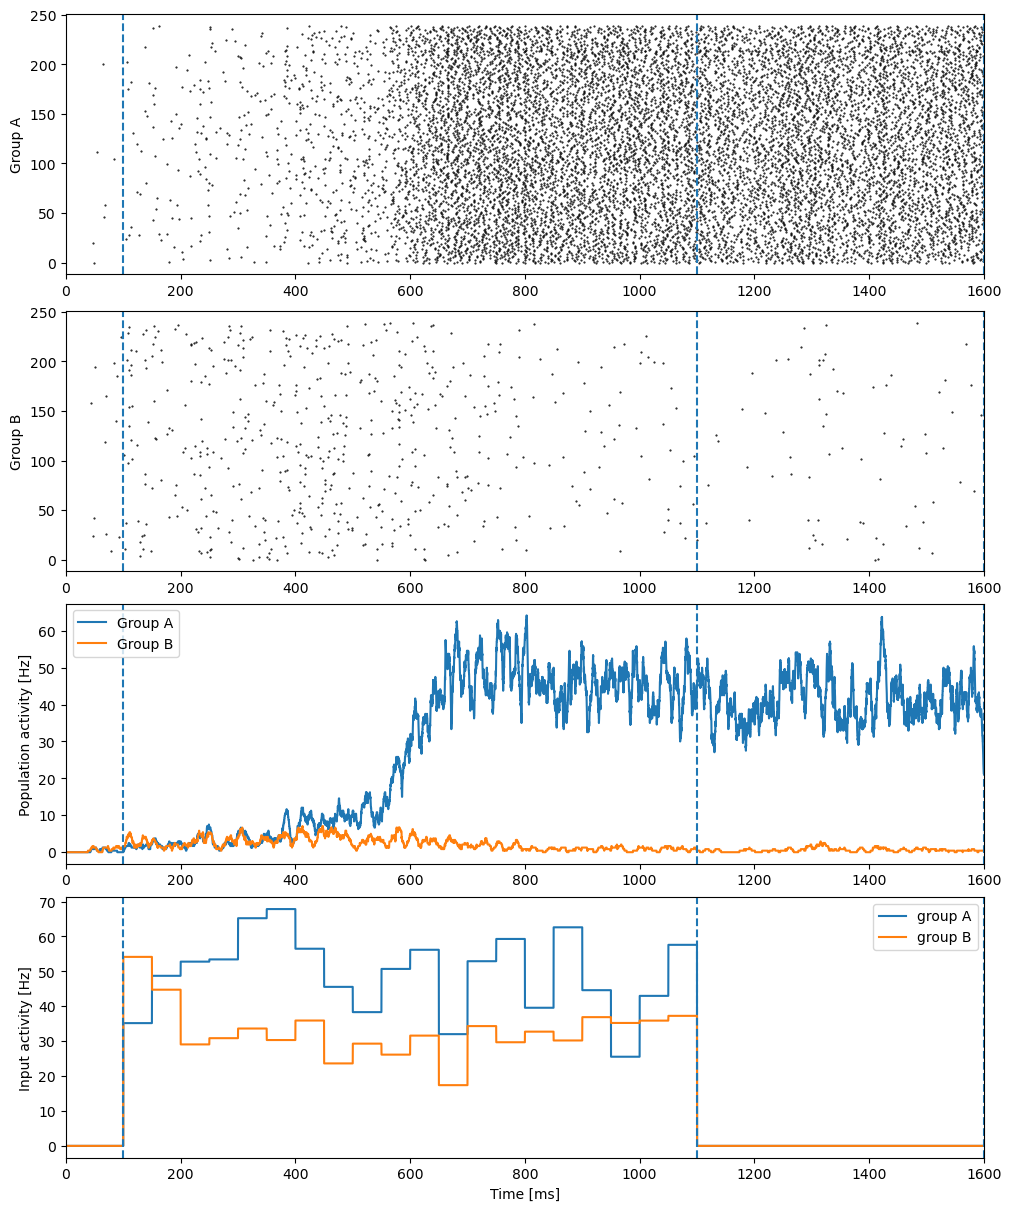

In [5]:
tool = Tool()
net = DecisionMakingNet()

mu0 = 40.
coherence = 25.6
IA_freqs = tool.generate_freqs(mu0 + mu0 / 100. * coherence)
IB_freqs = tool.generate_freqs(mu0 - mu0 / 100. * coherence)

def give_input():
    i = bp.share['i']
    net.IA.freqs[0] = IA_freqs[i]
    net.IB.freqs[0] = IB_freqs[i]

runner = bp.DSRunner(net, inputs=give_input, monitors=['A.spike', 'B.spike'])
runner.run(tool.total_period)
tool.visualize_results(runner.mon, IA_freqs, IB_freqs)


  0%|          | 0/16000 [00:00<?, ?it/s]

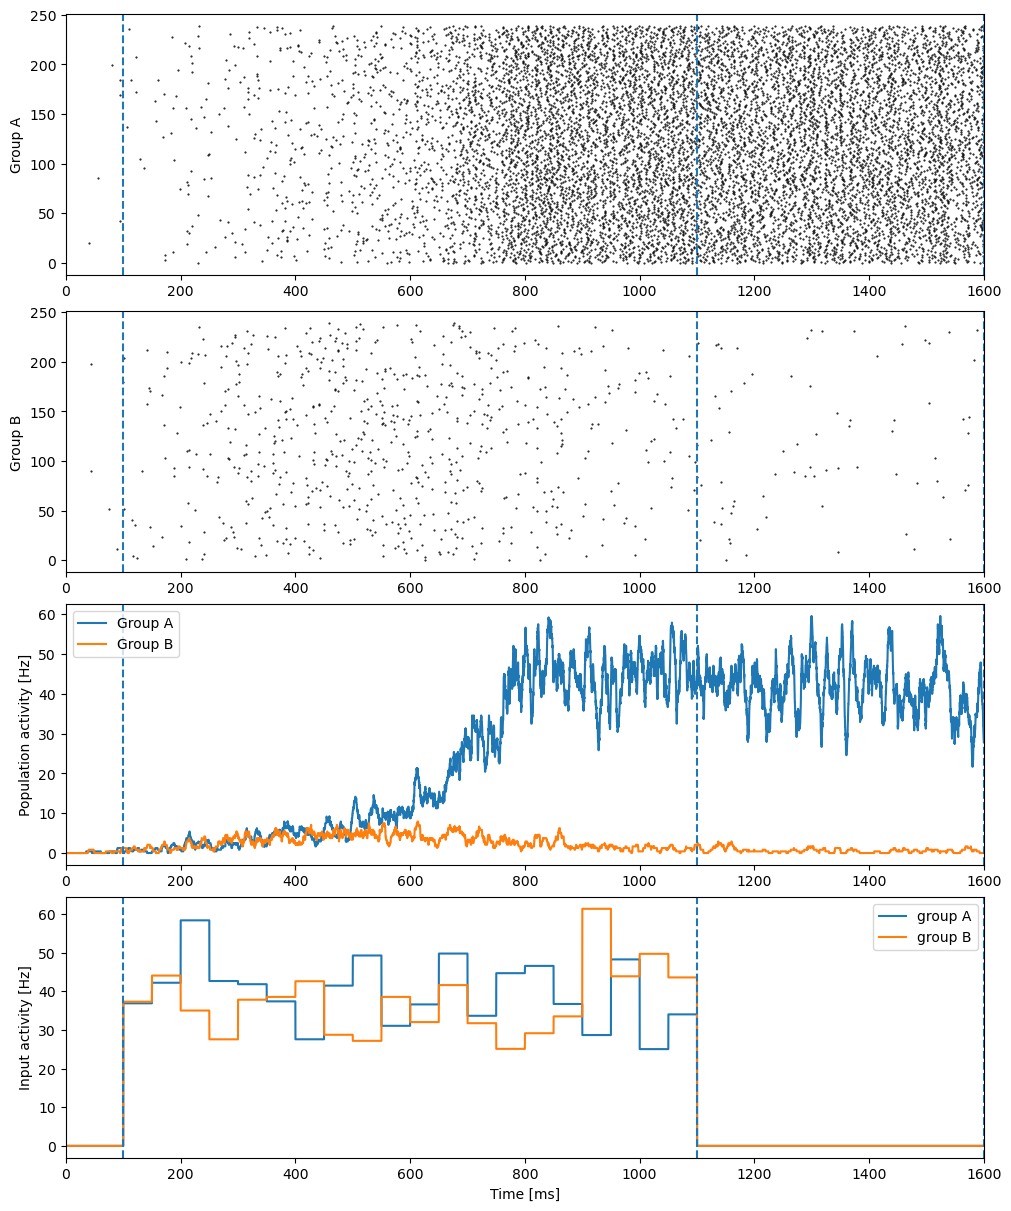

  0%|          | 0/16000 [00:00<?, ?it/s]

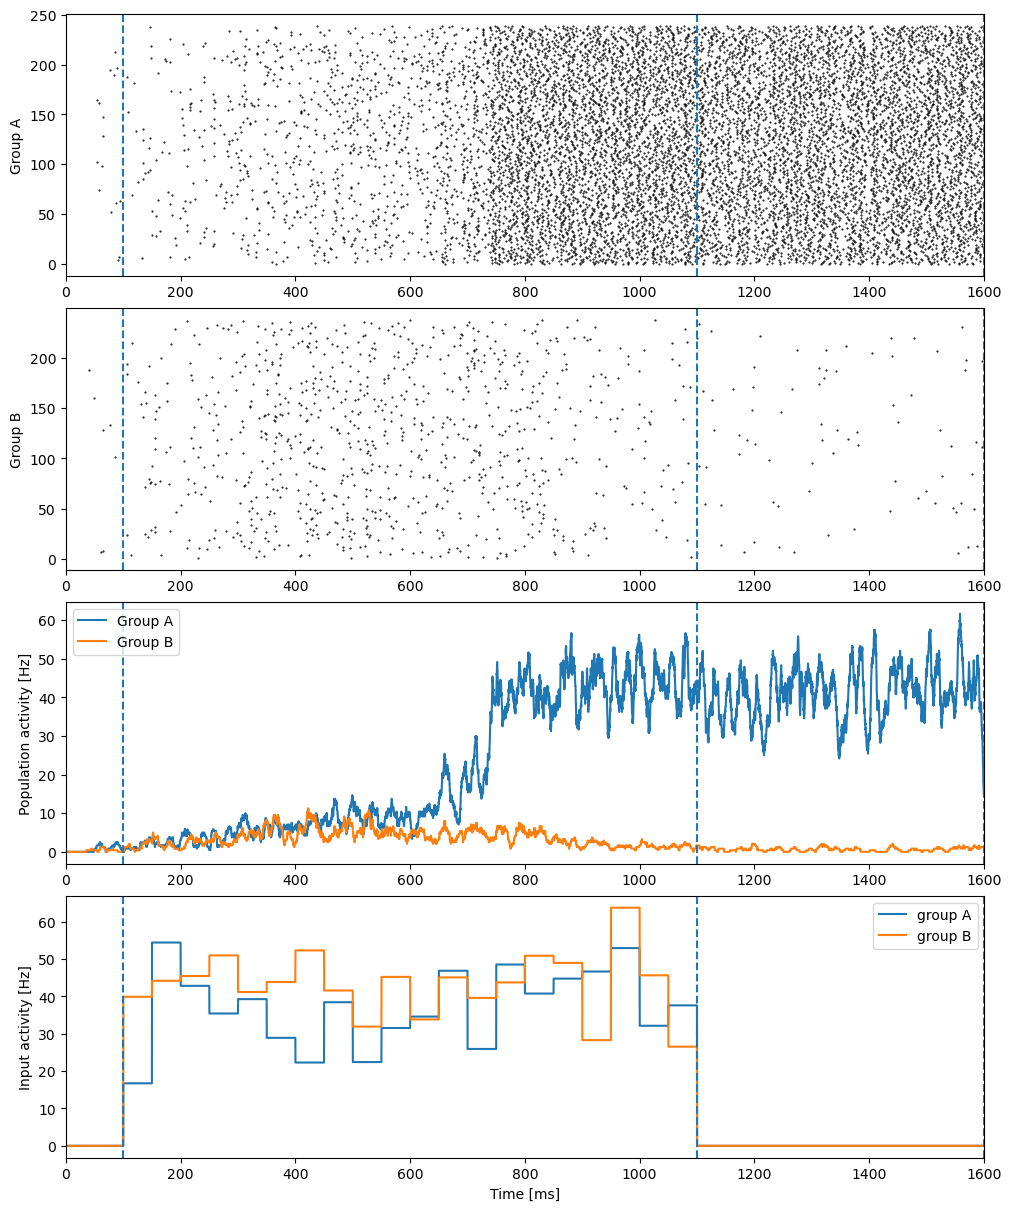

In [6]:
#测试多次随机猜测时候决策网路的表现
tool = Tool()
net = DecisionMakingNet()

mu0 = 40.
coherence = 0.
IA_freqs = tool.generate_freqs(mu0 + mu0 / 100. * coherence)
IB_freqs = tool.generate_freqs(mu0 - mu0 / 100. * coherence)

def give_input():
    i = bp.share['i']
    net.IA.freqs[0] = IA_freqs[i]
    net.IB.freqs[0] = IB_freqs[i]

runner = bp.DSRunner(net, inputs=give_input, monitors=['A.spike', 'B.spike'])
runner.run(tool.total_period)
tool.visualize_results(runner.mon, IA_freqs, IB_freqs)

tool = Tool()
net = DecisionMakingNet()

mu0 = 40.
coherence = 0.
IA_freqs = tool.generate_freqs(mu0 + mu0 / 100. * coherence)
IB_freqs = tool.generate_freqs(mu0 - mu0 / 100. * coherence)

def give_input():
    i = bp.share['i']
    net.IA.freqs[0] = IA_freqs[i]
    net.IB.freqs[0] = IB_freqs[i]

runner = bp.DSRunner(net, inputs=give_input, monitors=['A.spike', 'B.spike'])
runner.run(tool.total_period)
tool.visualize_results(runner.mon, IA_freqs, IB_freqs)